In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.sparse import csr_matrix, lil_matrix, identity

from tqdm import tqdm_notebook

In [2]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)

## Build the map

In [3]:
def box_house(posx, posy, x, y):
    h_size = 18
    return (posx < x < posx + h_size and
            posy < y < posy + h_size)


def l_house(posx, posy, x, y):
    if (posx < x < posx + 18 and
        posy < y < posy + 78):
        return True

    posx -= 12
    posy += 60

    return (posx < x < posx + 13 and
            posy < y < posy + 18)


def L_house(posx, posy, x, y):
    if (posx < x < posx + 18 and
        posy < y < posy + 78):
        return True

    posx += 12

    return (posx < x < posx + 12 and
            posy < y < posy + 18)


def is_in_house(x, y):
    boxes = [(69, 111), (69, 264),
             (138, 12), (138, 165),
             (192, 111), (192, 264),
             (261, 12), (261, 165)]

    L_houses = [(69, 12), (69, 165),
                (192, 12), (192, 165)]

    l_houses = [(138, 51), (138, 204),
                (261, 51), (261, 204)]

    for box in boxes:
        if box_house(*box, x, y):
            return True

    for house in L_houses:
        if L_house(*house, x, y):
            return True

    for house in l_houses:
        if l_house(*house, x, y):
            return True
    return False

### Check the map

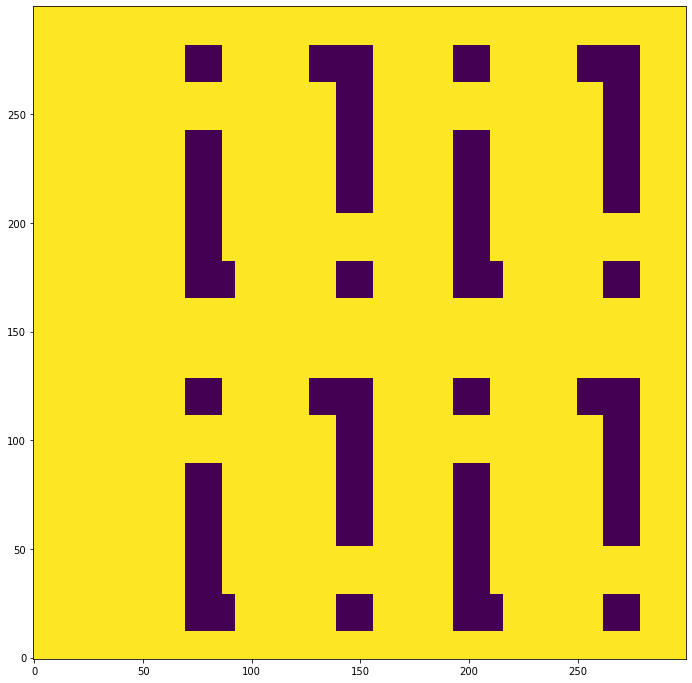

In [4]:
grid_size = 300
houses = np.zeros((grid_size * grid_size, 1))
    
houses_ids = [is_in_house(i, j) for i in range(grid_size) for j in range(grid_size)]
houses[houses_ids, 0] = -1
houses = houses.reshape((grid_size, grid_size))

plt.imshow(houses.T)
plt.gca().invert_yaxis()
plt.show()

## Calculate convection-diffusion equation

Change is less than epsilon. Terminating at step: 36035


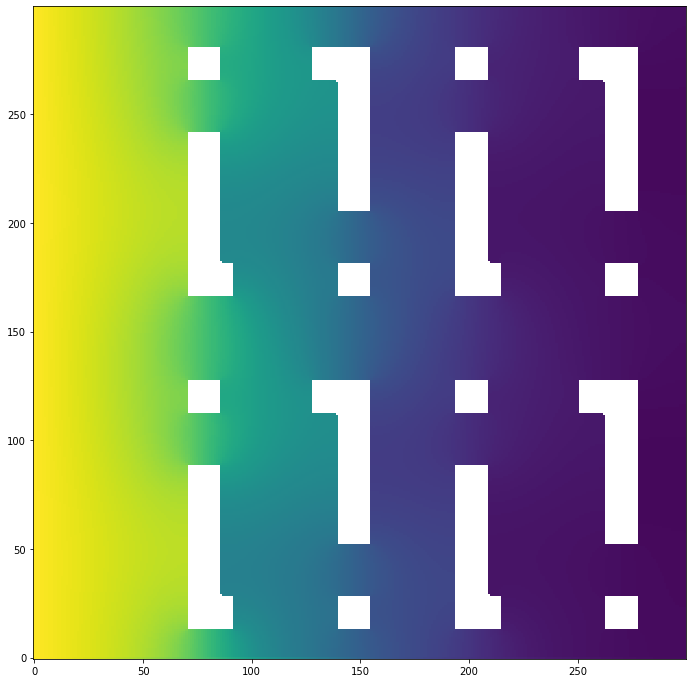

In [5]:
def convDiff(k, lambda_x, lambda_y, n_iters,
                grid_size=300, h=1, eps=1e-8, tau_coeff=1,
               save_video=False):
    tau = tau_coeff * h ** 2 / (4 * k)

    N = grid_size * grid_size

    # Init Concentration.
    u = np.zeros((N, 1))
    y0 = np.array(range(grid_size))
    
    # Add Houses as bad values.
    houses_ids = [is_in_house(i, j) for i in range(grid_size) for j in range(grid_size)]
    u[houses_ids, 0] = -1
    
    # Init transition matrix.
    A = lil_matrix((N, N))
    
    dx = [1, -1, 0, 0]
    dy = [0, 0, 1, -1]
    common = k / (h ** 2)
    u0coeff = (1 - 4 * tau * common)
    coeffs = [tau * (common - lambda_x / (2 * h)),
              tau * (common + lambda_x / (2 * h)),
              tau * (common - lambda_y / (2 * h)),
              tau * (common + lambda_y / (2 * h))]
    
    for x in range(0, grid_size, 1):
        for y in range(0, grid_size, 1):
            ind = x * grid_size + y
            # If the most left coorinate, keep val at 1.
            if x == 0:
                A[ind, ind] = 1
                continue
            A[ind, ind] = u0coeff
            for x_off, y_off, coeff in zip(dx, dy, coeffs):
                x_neig, y_neig = x + x_off, y + y_off
                
#                 elif x_neig == 300:
#                     A[ind, ind] -= coeff
                if (
                    (x_neig >= grid_size and abs(x_off)) or # (du/dx)_{x=300} = 0
                    (y_neig >= grid_size and abs(y_off)) or # (du/dy)_{y=300} = 0
                    (y_neig == 0 and abs(y_off))            # (du/dy)_{y=0} = 0
                   ):          
                    A[ind, ind] += coeff
                elif is_in_house(x_neig, y_neig):
                    A[ind, ind] += coeff
                else:
                    A[ind, x_neig * grid_size + y_neig] = coeff

    A = csr_matrix(A)
    
    # Calculate results.
    u[y0, 0] = 1
    ims = []
    for i in tqdm_notebook(range(n_iters), total=n_iters):
        u_new = A * u
        if save_video and i % 200 == 0:
            im = plt.imshow(u_new.reshape((grid_size, grid_size)).T, animated=True, cmap=current_cmap)
            plt.clim(0, 1)
            plt.gca().invert_yaxis()
            ims.append([im])
        error = np.max(np.abs(u_new - u))
        if error < eps:
            print("Change is less than epsilon. Terminating at step:", i)
            break
        u = u_new
    
    return u.reshape((grid_size, grid_size)), ims

# Given parameters
k = 0.5
lambda_x = 1
lambda_y = 0
# Non-changeable params (for current implementation)
grid_size = 300
# Changeable parameters
n_iters = int(1e4 * 5)
eps = 10e-6
tau_coeff = 1
h = 1/300
save_video =False
video_path = 'out_test.mp4' # If you get error about ffmpeg, change to `.gif` (may help)

# Create a cmap, which will display out of bound values (our houses) with different color.
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')
current_cmap.set_under('white')

# Solve.
u_res, ims = convDiff(k, lambda_x, lambda_y, n_iters,
                grid_size, h, eps, tau_coeff=tau_coeff,
                save_video=save_video)

# Save video.
if save_video:
    fig = plt.figure()
    plt.colorbar()
    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
    from matplotlib.animation import PillowWriter
    ani.save(video_path)
    

# Plot.
plt.imshow(u_res.T, cmap=current_cmap)
plt.gca().invert_yaxis()
# plt.colorbar()
plt.clim(0, 1)
plt.show()

## Output

In [6]:
res_path = 'res.txt'

### Output as stated in the task

In [7]:
with open(res_path, 'w') as out_file:
    out_file.write(str(grid_size) + '\n')
    for x in range(0, grid_size, 1):
        out_file.write(' '.join(map(lambda y: ' '.join(map(str, (x, y, u_res[x, y]))), range(0, grid_size, 1))) + '\n')

# print(grid_size)
# for x in range(0, grid_size, 1):
#     print(' '.join(map(lambda y: ' '.join(map(str, (x, y, u_res[x, y]))), range(0, grid_size, 1))))

### Output as stated by Ivan G

In [8]:
with open(res_path, 'w') as out_file:
    out_file.write(str(grid_size) + '\n')
    for x in range(0, grid_size, 1):
        out_file.write(' '.join(map(lambda y: str(u_res[x, y]), range(0, grid_size, 1))) + '\n')

# print(grid_size)
# for x in range(0, grid_size, 1):
#     print(' '.join(map(lambda y: str(u_res[x, y]), range(0, grid_size, 1))))